In [6]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append("../")

In [8]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [9]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [10]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [11]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

/scratch/sm8383/miniconda3/envs/sbi-fermi/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/scratch/sm8383/miniconda3/envs/sbi-fermi/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/scratch/sm8383/miniconda3/envs/sbi-fermi/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered col

torch.Size([1, 16384, 1])

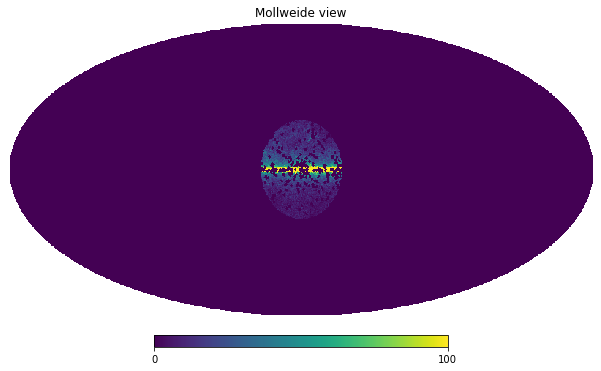

In [12]:
in_map = np.load("../data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [14]:
sg = SphericalGraphCNN(nside_list, indexes_list).to(device)

In [15]:
in_map = torch.ones((1,16385,1))

In [16]:
in_map = in_map.to(device)

In [17]:
sg(in_map).shape

torch.Size([1, 512])

## Test data generation

In [102]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_dif = np.load("../data/fermi_data/template_dif.npy")

In [103]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [104]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [105]:
from simulations.wrapper import simulator

In [106]:
import sys
from sbi import utils
from sbi import inference

In [107]:
0.1 * np.mean(np.load("../data/fermi_data/fermidata_counts.npy")[np.where(~masks_list[0])])

2.8128173828125003

In [108]:
np.mean(temp_gce[~masks_list[0]])

1.0441547502963613

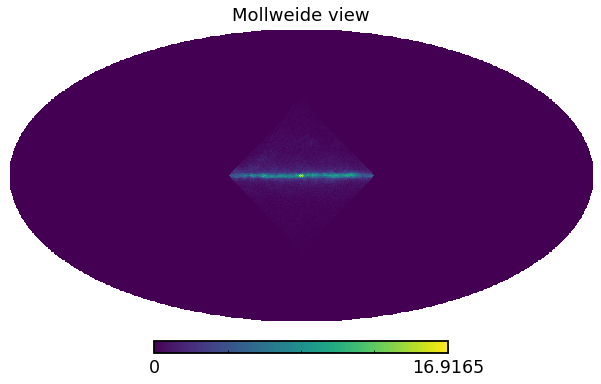

In [109]:
theta = [0.3, 0.1, 20., 1.9, -10., 5., 0.1]
test_map_temp = simulator(theta, masks_list[0], temp_gce, pc_inst.psf_r_func, temp_dif)
test_map = np.zeros(hp.nside2npix(128))
test_map[np.where(~masks_list[0])] = test_map_temp[0, :-1]
hp.mollview(test_map)

In [110]:
test_map_temp[0, -1]

21.931278608483368

In [111]:
from tqdm import *

In [112]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.001, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1]), high=torch.tensor([0.5, 0.5, 20.0, 1.99, 1.99, 50.0, 4.99]))

In [42]:
np.sum(~masks_list[0])

16384

In [163]:
number_presimulated = 100

theta_presimulated = prior.sample((number_presimulated,))
x_presimulated = [simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func) for theta in tqdm(theta_presimulated)]

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


In [255]:
# theta_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/theta_train_0.npy")
# x_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/x_train_0.npy")

In [165]:
len(x_presimulated)

100

In [168]:
invalid_idx = np.ones(len(x_presimulated)).astype(np.int32)
for idx in tqdm(range(len(x_presimulated))):
    if np.sum(np.isnan(x_presimulated[idx])) + np.sum(np.isinf(x_presimulated[idx])):
        invalid_idx[idx] = 0

100%|██████████| 100/100 [00:00<00:00, 18302.15it/s]


In [169]:
x_presimulated = np.array(x_presimulated)[invalid_idx.astype(bool)]
theta_presimulated = np.array(theta_presimulated)[invalid_idx.astype(bool)]

In [170]:
len(theta_presimulated)

100

In [171]:
np.save("../data/samples/x_small_train.npy", x_presimulated)
np.save("../data/samples/theta_small_train.npy", theta_presimulated)

In [172]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [27]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

## SNPE

In [28]:
from sbi.inference import SNPE

In [29]:
device.type

'cuda'

In [30]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = SNPE(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                          device=device.type)

../sbi/utils/torchutils.py:31: UserWarning: GPU was selected as a device for training the neural network. Note
                   that we expect **no** significant speed ups in training for the
                   default architectures we provide. Using the GPU will be effective
                   only for large neural networks with operations that are fast on the
                   GPU, e.g., for a CNN or RNN `embedding_net`.
  GPU, e.g., for a CNN or RNN `embedding_net`."""


In [31]:
# density_estimator = inference_inst.train(x="/scratch/sm8383/sbi-fermi/data/samples/x_train.npy",
#                                          theta="/scratch/sm8383/sbi-fermi/data/samples/theta_train.npy",
#                                          proposal=prior,
#                                          training_batch_size=100, max_num_epochs=50)

In [32]:
density_estimator = torch.load("../data/models/vanilla.pt")

In [33]:
posterior = inference_inst.build_posterior(density_estimator)

In [34]:
x_presimulated = torch.Tensor(np.load("../data/samples/x_train_100.npy"))
theta_presimulated = torch.Tensor(np.load("../data/samples/theta_train_100.npy"))

In [35]:
torch.argmin(theta_presimulated[:, 0]), torch.argmax(theta_presimulated[:, 0])

(tensor(915), tensor(697))

In [36]:
torch.argmin(theta_presimulated[:, 1]), torch.argmax(theta_presimulated[:, 1])

(tensor(196), tensor(742))

In [37]:
import corner

In [38]:
x_presimulated.shape

torch.Size([1000, 1, 16385])

In [39]:
x_presimulated[0].view(-1, 16385, 1).shape

torch.Size([1, 16385, 1])

In [40]:
x_presimulated

tensor([[[0.0000, 0.0000, 5.6637,  ..., 0.0000, 0.0000, 0.1766]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5974]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7688]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6723]],

        [[0.0000, 2.4245, 0.0000,  ..., 0.0000, 0.0000, 0.4125]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4208]]])

In [41]:
truth_idx = 10
x_o = x_presimulated[truth_idx]
posterior_samples = posterior.sample((4000,), x=x_o)

In [42]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

(0.1, 100.0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


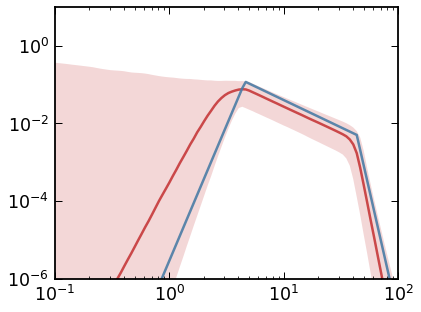

In [43]:
from models.scd import dnds

truth_idx = 18
x_o = x_presimulated[truth_idx]
posterior_samples = posterior.sample((4000,), x=x_o)

s_ary = np.logspace(-1, 2, 100)
dnds_ary = [dnds(s_ary, theta) for theta in posterior_samples[:,1:].detach().numpy()]
plt.plot(s_ary, np.median(dnds_ary, axis=0))
plt.fill_between(s_ary, np.percentile(dnds_ary, [5.], axis=0)[0], np.percentile(dnds_ary, [95.], axis=0)[0], alpha=0.2)
theta_truth = theta_presimulated[truth_idx]
plt.plot(s_ary, dnds(s_ary, theta_truth[1:].detach().numpy()))

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-6, 1e1)
plt.xlim(1e-1, 1e2)

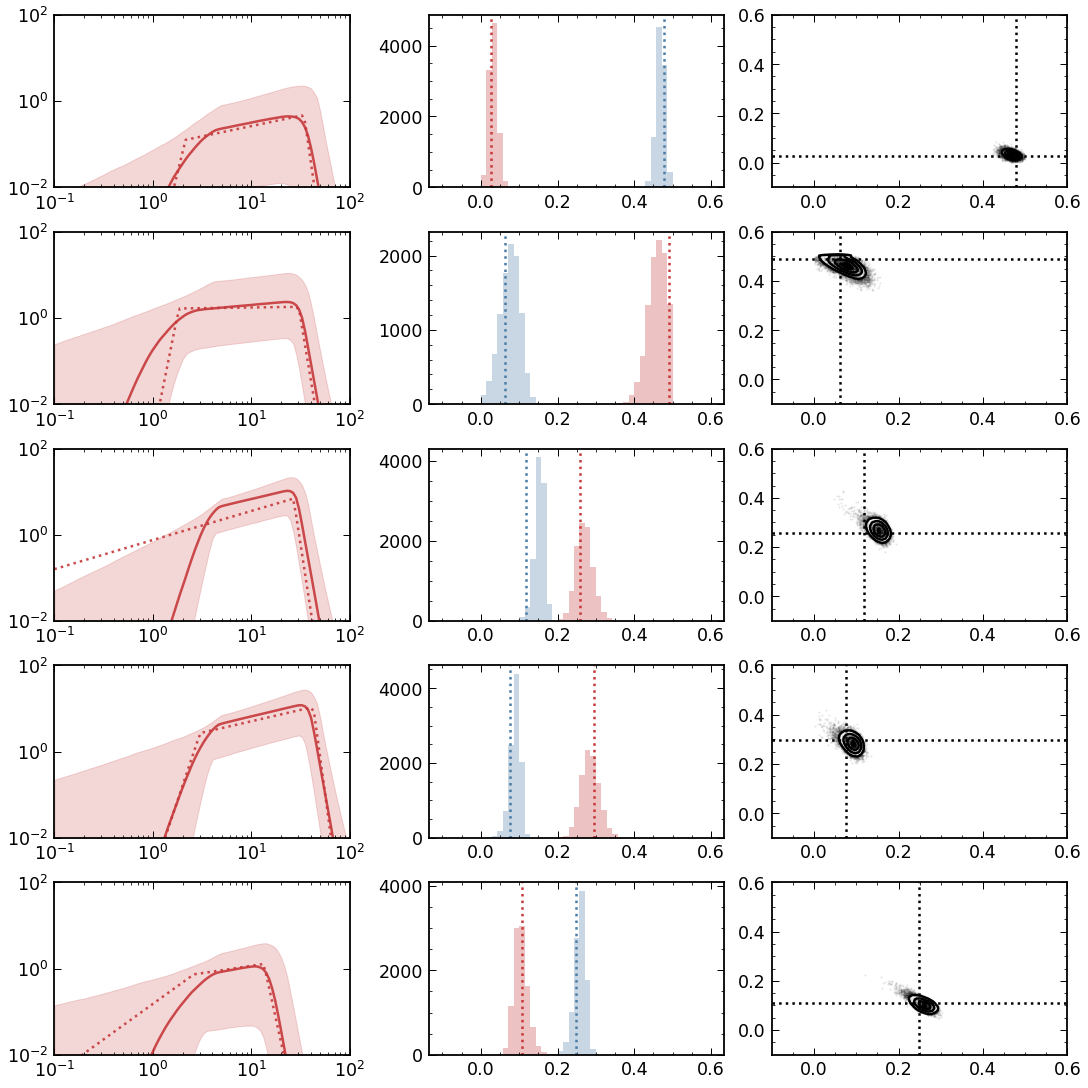

In [113]:
nrows = 5
idx_start = 20
fig, ax = plt.subplots(ncols=3, nrows=nrows, constrained_layout=True, figsize=(15, 15))

for i_r in range(nrows):
    
    truth_idx = idx_start + i_r
    x_o = x_presimulated[truth_idx]
    posterior_samples = posterior.sample((10000,), x=x_o)

    s_ary = np.logspace(-1, 2, 100)
    dnds_ary = [dnds(s_ary, theta) for theta in posterior_samples[:,1:].detach().numpy()]
    
    ax[i_r, 0].plot(s_ary, np.median(s_ary ** 2 * dnds_ary, axis=0), color=cols_default[0])
    ax[i_r, 0].fill_between(s_ary, np.percentile(s_ary ** 2 * dnds_ary, [2.5], axis=0)[0], np.percentile(s_ary ** 2 * dnds_ary, [97.5], axis=0)[0], alpha=0.2, color=cols_default[0])
    theta_truth = theta_presimulated[truth_idx]
    ax[i_r, 0].plot(s_ary, s_ary ** 2 * dnds(s_ary, theta_truth[1:].detach().numpy()), color=cols_default[0], ls='dotted')

    ax[i_r, 0].set_xscale("log")
    ax[i_r, 0].set_yscale("log")

    ax[i_r, 0].set_ylim(1e-2, 1e2)
    ax[i_r, 0].set_xlim(1e-1, 1e2)
    
    bins = np.linspace(-0.1, 0.6, 50)
    ax[i_r, 1].hist(posterior_samples[:,0].detach().numpy(), bins=bins, alpha=0.3, color=cols_default[1]);
    ax[i_r, 1].hist(posterior_samples[:,1].detach().numpy(), bins=bins, alpha=0.3, color=cols_default[0]);
    ax[i_r, 1].axvline(theta_truth[0], color=cols_default[1], ls='dotted')
    ax[i_r, 1].axvline(theta_truth[1], color=cols_default[0], ls='dotted')
    corner.hist2d(posterior_samples[:,0].detach().numpy(), posterior_samples[:,1].detach().numpy(), ax=ax[i_r, 2], smooth=1)
    ax[i_r, 2].axvline(theta_truth[0], color='k', ls='dotted')
    ax[i_r, 2].axhline(theta_truth[1], color='k', ls='dotted')
    ax[i_r, 2].set_xlim(-0.1, 0.6)
    ax[i_r, 2].set_ylim(-0.1, 0.6)
